In [9]:
from dpp.data import load_from_kaggle

# ============================================================
#  1. Setup & Imports
# ============================================================

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Machine learning (for later sections)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# ============================================================
#  2. Global Plot & Style Configuration
# ============================================================

# Unified font and size
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# Seaborn theme (modern, clean, scientific look)
sns.set_theme(
    style='whitegrid',
    font='DejaVu Sans',
    rc={'font.size': 14}
)

# Unified color palette (Blue / Orange)
PRIMARY_COLOR = '#1f77b4'   # Blue
SECONDARY_COLOR = '#ff7f0e' # Orange
PALETTE = sns.color_palette([PRIMARY_COLOR, SECONDARY_COLOR])

# Apply the palette globally
sns.set_palette(PALETTE)

print("✅ Environment ready — all styles, fonts, and colors set.")


✅ Environment ready — all styles, fonts, and colors set.


Destination directory '../data/raw\machine-predictive-maintenance-classification' already exists with files. Skipping download (replace=False).


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.100,308.600,1551,42.800,0,0,No Failure
1,2,L47181,L,298.200,308.700,1408,46.300,3,0,No Failure
2,3,L47182,L,298.100,308.500,1498,49.400,5,0,No Failure
3,4,L47183,L,298.200,308.600,1433,39.500,7,0,No Failure
4,5,L47184,L,298.200,308.700,1408,40.000,9,0,No Failure



🔹 Dataset shape: (10000, 10)

🔹 Columns and data types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


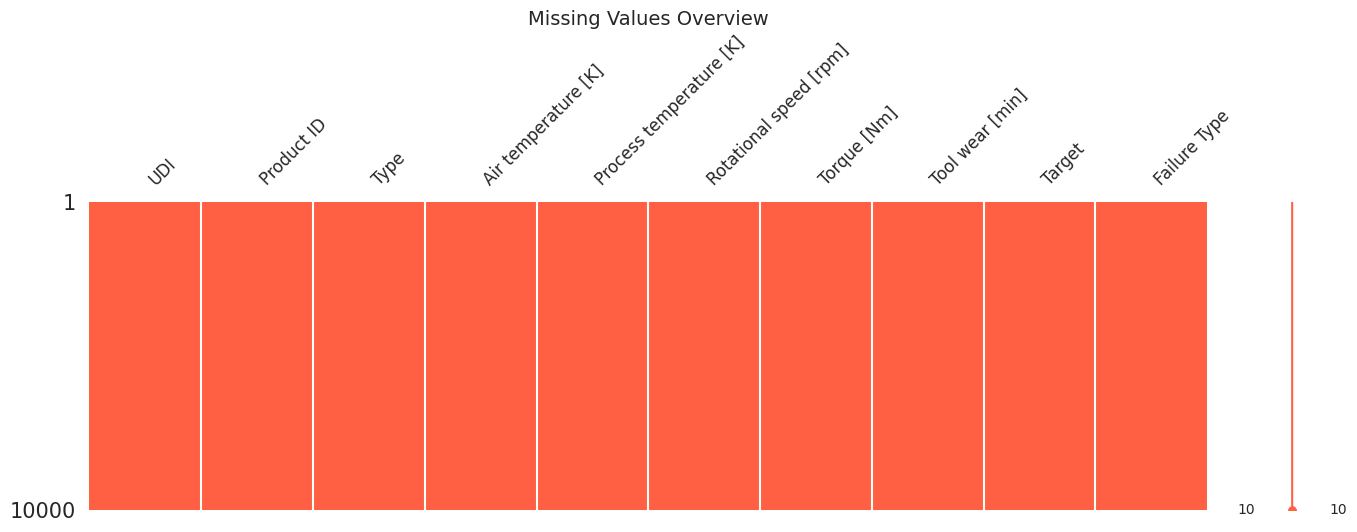

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.500000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.895680,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.750000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.500000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.250000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000



🔹 Missing values per column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

🔹 Categorical columns: ['Type', 'Failure Type']

✅ Encoding completed. Updated dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.199400,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,1.039000
std,0.600230,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.379069
min,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000
25%,1.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,1.000000
50%,1.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,1.000000
75%,2.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,1.000000
max,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,5.000000


In [10]:
# ============================================================
#  3. Data Loading
# ============================================================

# Load the predictive maintenance dataset from Kaggle
dataset_link = "shivamb/machine-predictive-maintenance-classification"  
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))

# Quick check of the first rows
display(df.head())

# Overview of the dataset
print("\n🔹 Dataset shape:", df.shape)
print("\n🔹 Columns and data types:")
print(df.dtypes)

# ============================================================
#  4. Basic Cleaning
# ============================================================

# Check for missing values visually
msno.matrix(df, figsize=(16, 4), fontsize=12, color=(1, 0.38, 0.27))
plt.title("Missing Values Overview", fontsize=14)
plt.show()

# Check numeric summary
display(df.describe().style.background_gradient(cmap="Blues"))

# Check for null values in each column
print("\n🔹 Missing values per column:")
print(df.isnull().sum())

# ============================================================
#  5. Data Preparation
# ============================================================

# Drop columns that are purely identifiers (not useful for modeling)
df = df.drop(columns=["UDI", "Product ID"])

# Encode categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns
print("\n🔹 Categorical columns:", list(cat_cols))

# Use LabelEncoder for categorical variables
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

print("\n✅ Encoding completed. Updated dataframe info:")
print(df.info())

# Quick statistical overview after cleaning
display(df.describe().style.background_gradient(cmap="Blues"))


C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Failure Type', data=df, palette=PALETTE)
C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:6: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='Failure Type', data=df, palette=PALETTE)


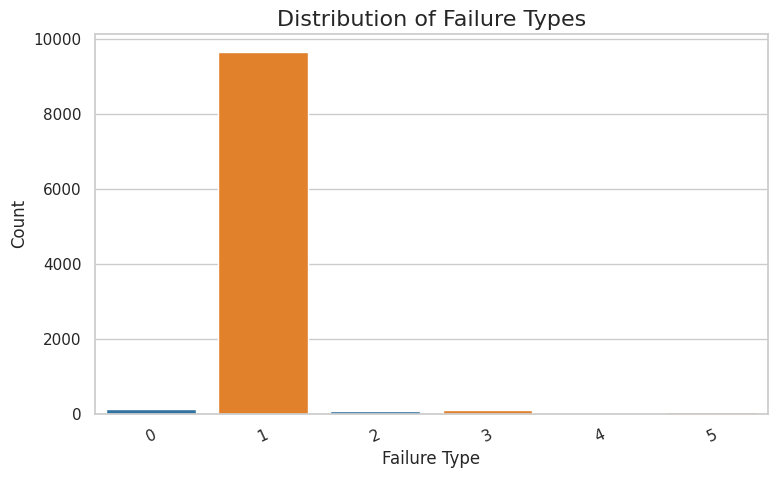

C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Type', data=df, palette=PALETTE)
C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:20: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='Type', data=df, palette=PALETTE)


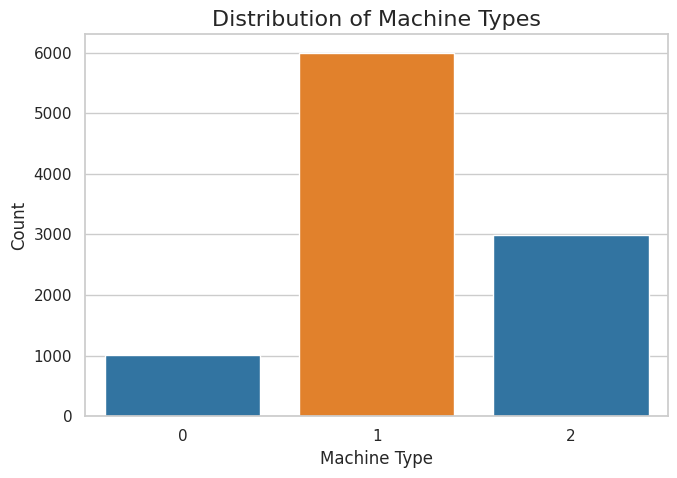

C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:33: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='Type', hue='Failure Type', data=df, palette=PALETTE)


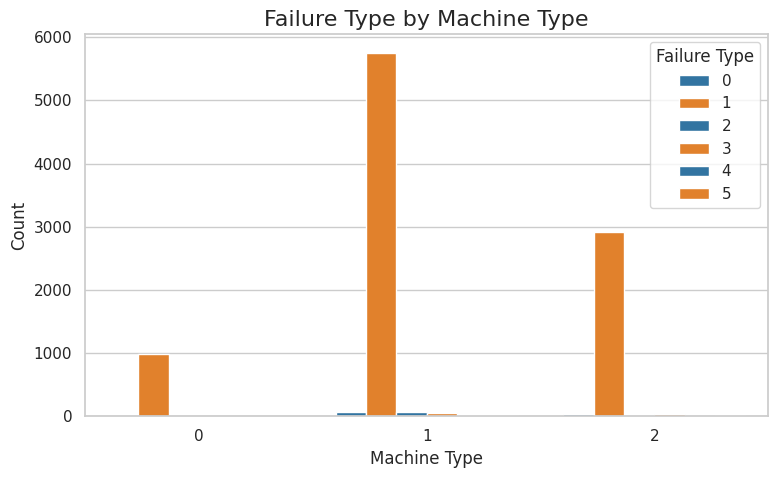

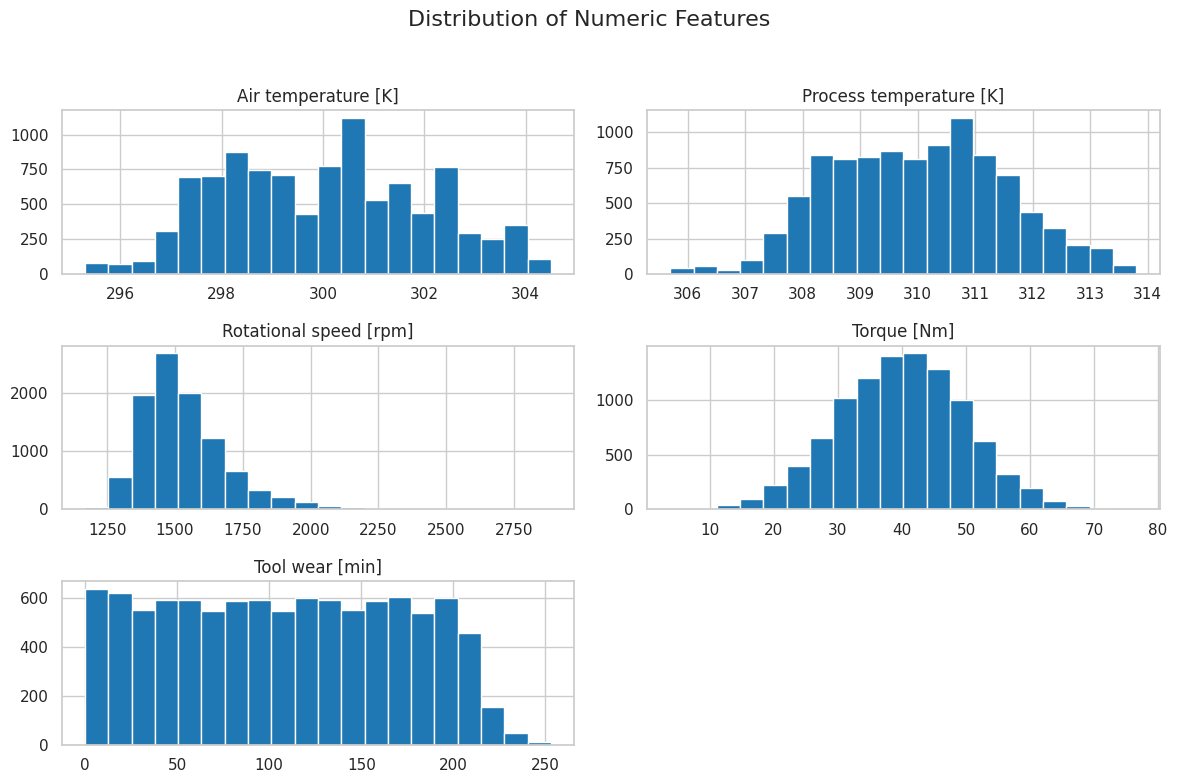

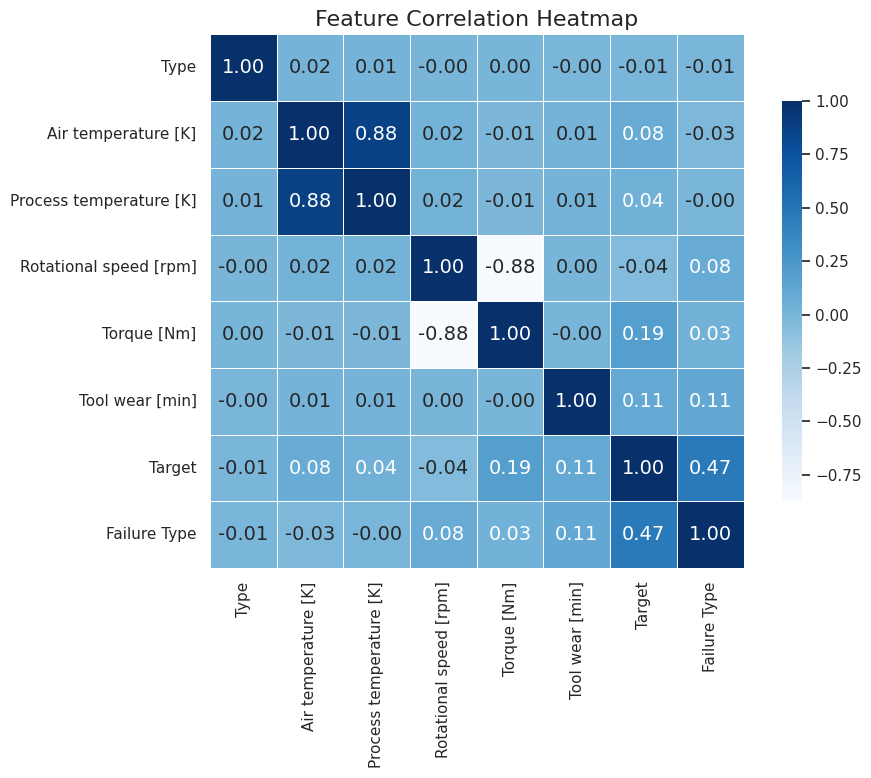

C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Failure Type', y=col, data=df, palette=PALETTE, ax=axes[i])
C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:88: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Failure Type', y=col, data=df, palette=PALETTE, ax=axes[i])
C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Failure Type', y=col, data=df, palette=PALETTE, ax=axes[i])
C:\Users\webco\AppData\Local\Temp\ipykernel_21228\1130583048.py:88: User

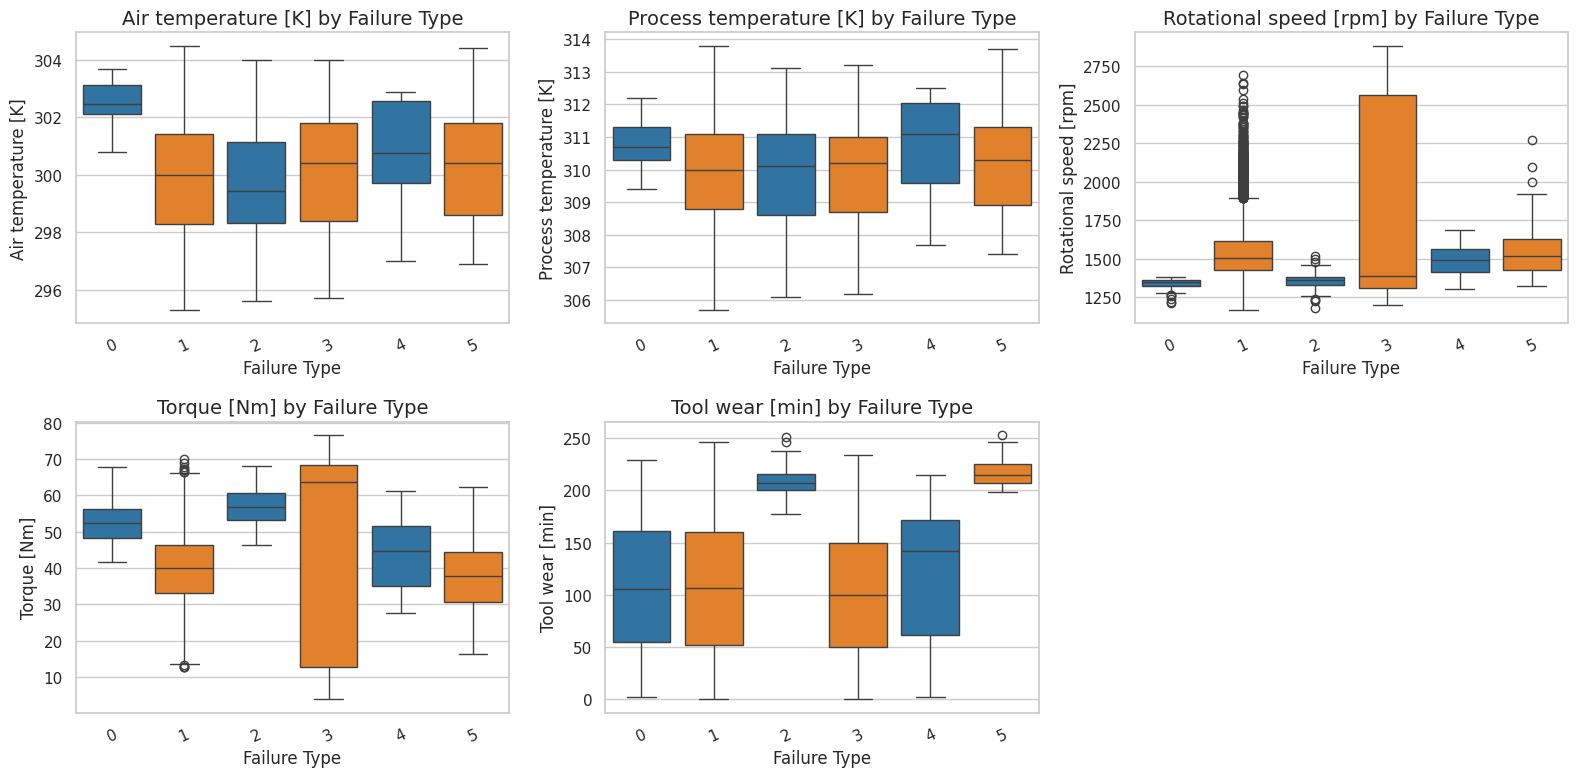

In [11]:
# ============================================================
#  6. Target Variable Distribution
# ============================================================

plt.figure(figsize=(8, 5))
sns.countplot(x='Failure Type', data=df, palette=PALETTE)
plt.title("Distribution of Failure Types", fontsize=16)
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


# ============================================================
#  7. Machine Type Distribution
# ============================================================

plt.figure(figsize=(7, 5))
sns.countplot(x='Type', data=df, palette=PALETTE)
plt.title("Distribution of Machine Types", fontsize=16)
plt.xlabel("Machine Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# ============================================================
#  8. Relationship between Machine Type and Failure Type
# ============================================================

plt.figure(figsize=(8, 5))
sns.countplot(x='Type', hue='Failure Type', data=df, palette=PALETTE)
plt.title("Failure Type by Machine Type", fontsize=16)
plt.xlabel("Machine Type")
plt.ylabel("Count")
plt.legend(title="Failure Type", loc='upper right')
plt.tight_layout()
plt.show()


# ============================================================
#  9. Distribution of Numeric Features
# ============================================================

numeric_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

df[numeric_cols].hist(figsize=(12, 8), bins=20, color=PRIMARY_COLOR)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ============================================================
#  10. Correlation Heatmap
# ============================================================

plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(
    corr,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}
)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


# ============================================================
#  11. Boxplots for Key Features
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Failure Type', y=col, data=df, palette=PALETTE, ax=axes[i])
    axes[i].set_title(f"{col} by Failure Type", fontsize=14)
    axes[i].set_xlabel("Failure Type")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=25)

# Remove any empty subplot if number of plots < grid size
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

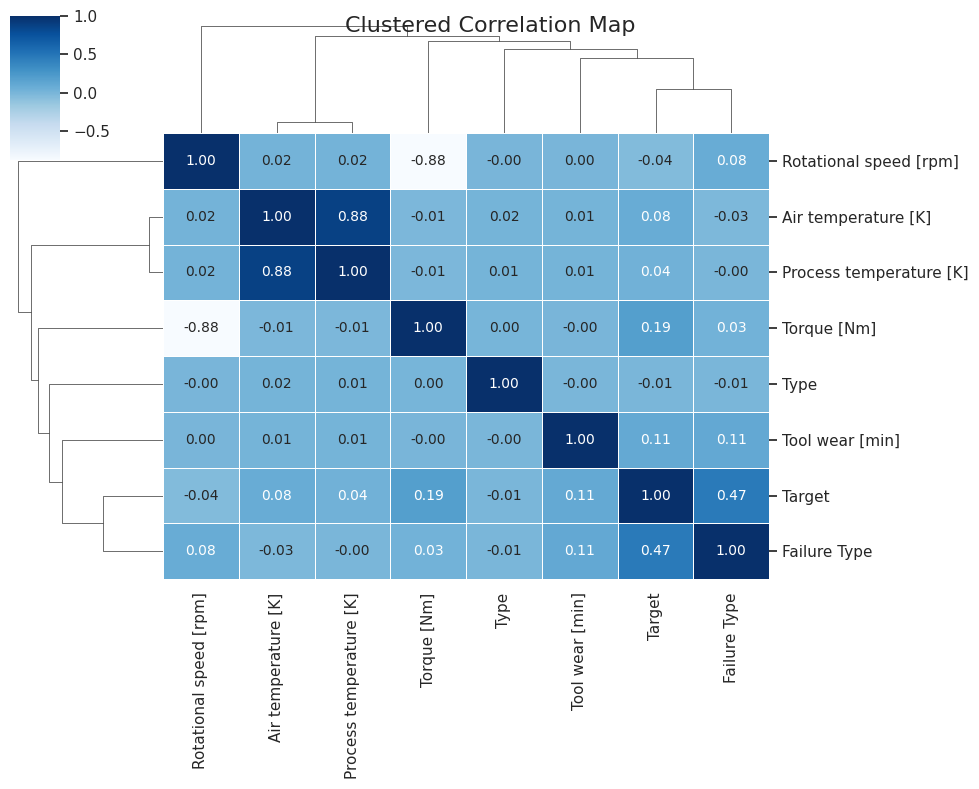

c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: 
The palette list 

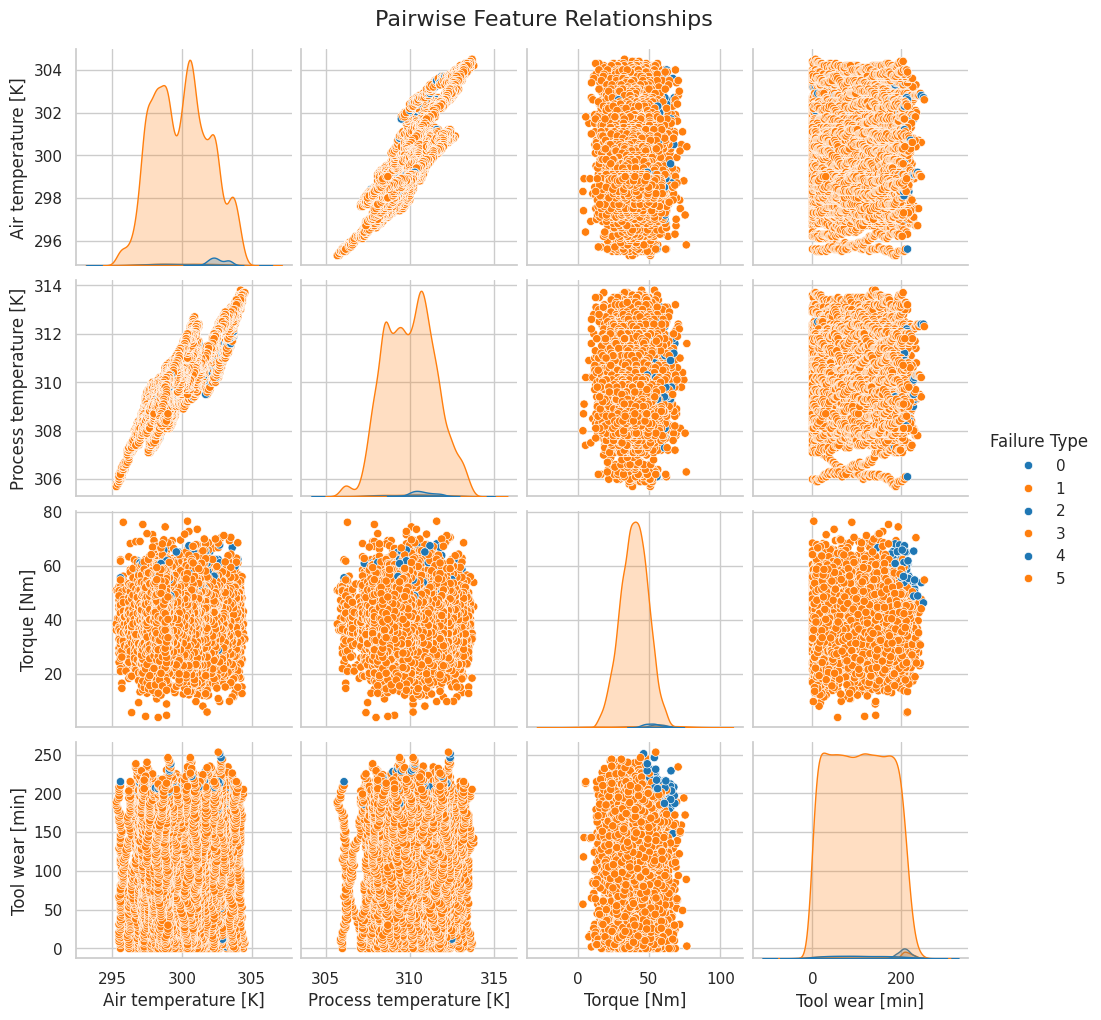

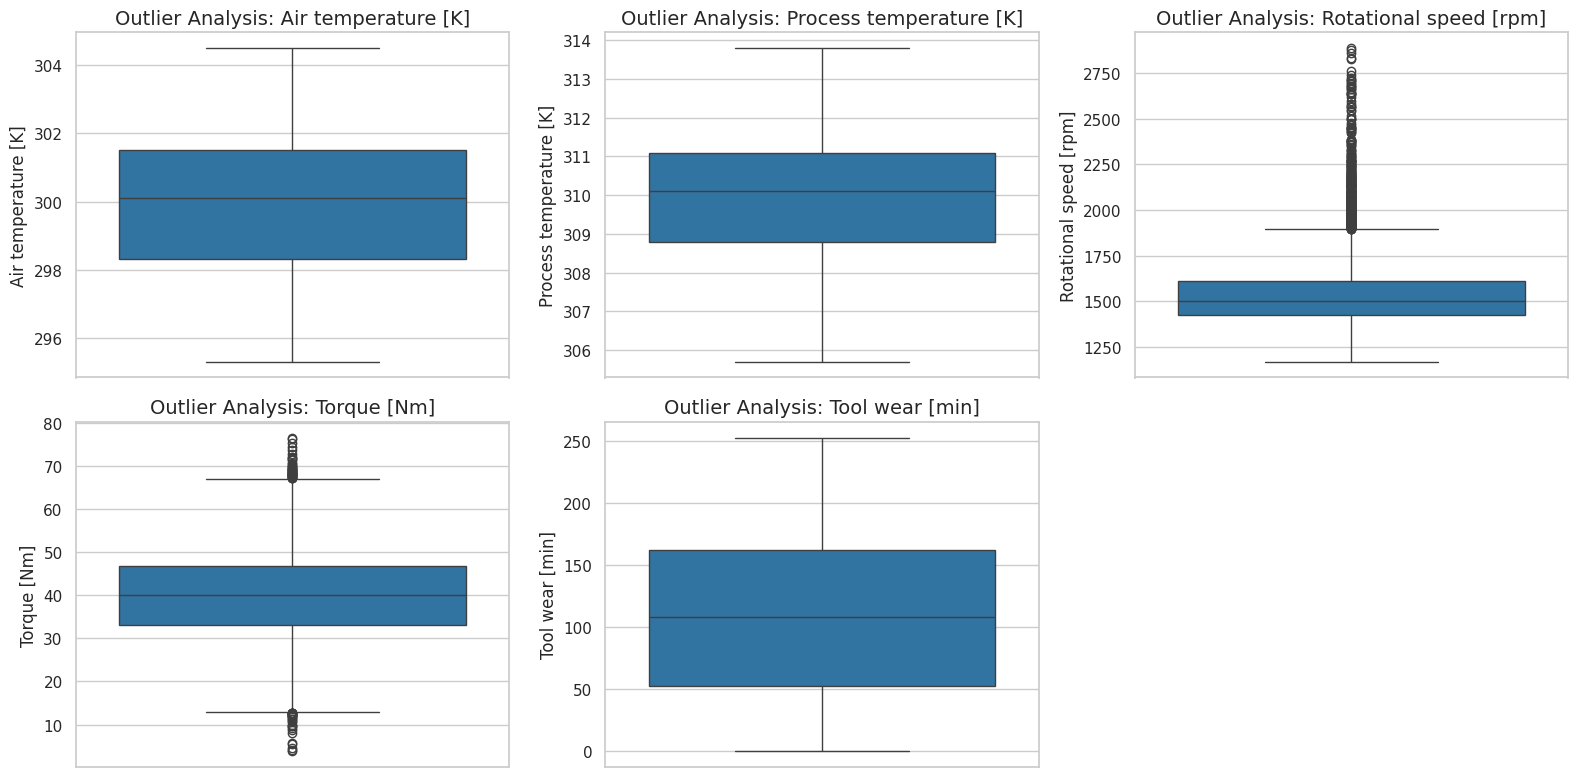

C:\Users\webco\AppData\Local\Temp\ipykernel_21228\715350306.py:78: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


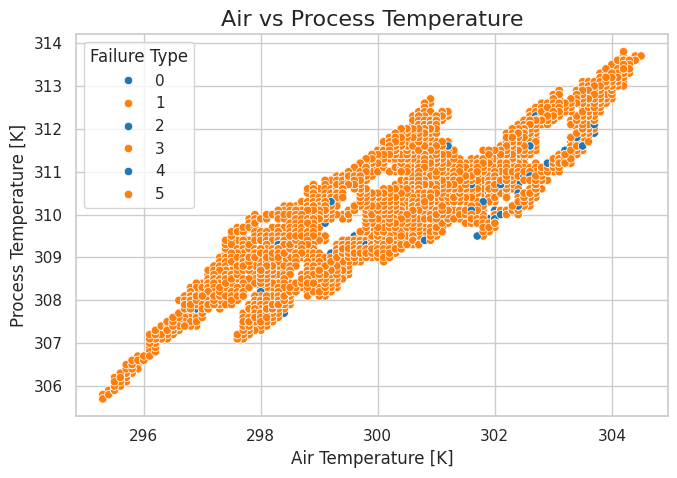

In [12]:
# ============================================================
# 12. Correlation Cluster Map
# ============================================================

# Create clustered heatmap to identify groups of correlated features
plt.figure(figsize=(10, 8))
sns.clustermap(
    df.corr(),
    cmap="Blues",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    figsize=(10, 8),
    annot_kws={"size": 10}
)
plt.suptitle("Clustered Correlation Map", fontsize=16)
plt.show()


# ============================================================
# 13. Pairplot for Key Variables
# ============================================================

sns.pairplot(
    df,
    vars=["Air temperature [K]", "Process temperature [K]", "Torque [Nm]", "Tool wear [min]"],
    hue="Failure Type",
    palette=PALETTE,
    diag_kind="kde",
    height=2.5
)
plt.suptitle("Pairwise Feature Relationships", fontsize=16, y=1.02)
plt.show()


# ============================================================
# 14. Outlier Detection (Boxplots per Feature)
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate([
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]):
    sns.boxplot(
        data=df,
        y=col,
        color=PRIMARY_COLOR,
        ax=axes[i]
    )
    axes[i].set_title(f"Outlier Analysis: {col}", fontsize=14)
    axes[i].set_ylabel(col)

# Remove unused subplot
for j in range(len([
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# ============================================================
# 15. Correlation Between Process and Air Temperature
# ============================================================

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="Air temperature [K]",
    y="Process temperature [K]",
    hue="Failure Type",
    data=df,
    palette=PALETTE
)
plt.title("Air vs Process Temperature", fontsize=16)
plt.xlabel("Air Temperature [K]")
plt.ylabel("Process Temperature [K]")
plt.legend(title="Failure Type")
plt.tight_layout()
plt.show()


✅ Model Accuracy: 0.996

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      1.00      1.00      1930
           2       0.80      1.00      0.89        16
           3       1.00      0.89      0.94        19
           4       0.00      0.00      0.00         4
           5       1.00      0.67      0.80         9

    accuracy                           1.00      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.99      1.00      0.99      2000



c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\webco\Downloads\DPP Data Analytics\DPP-Stackfuel-Data-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

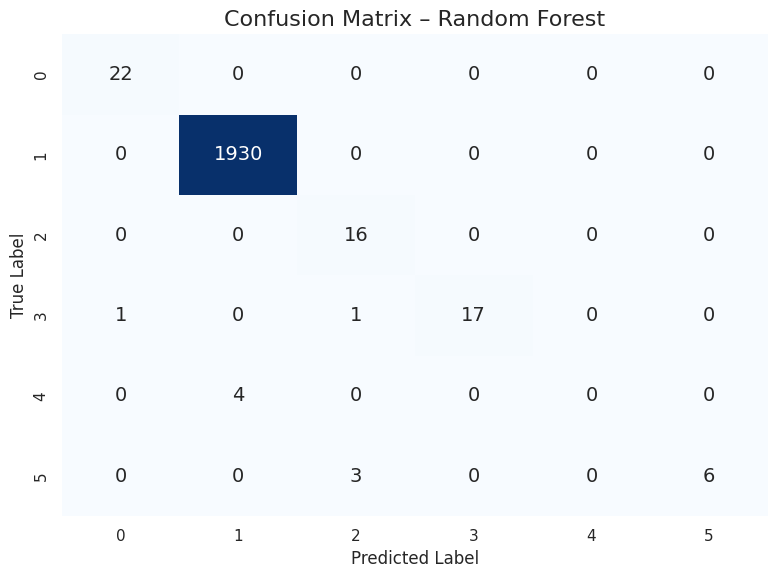

C:\Users\webco\AppData\Local\Temp\ipykernel_21228\3902057828.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette=PALETTE)
C:\Users\webco\AppData\Local\Temp\ipykernel_21228\3902057828.py:56: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=importances, y=importances.index, palette=PALETTE)


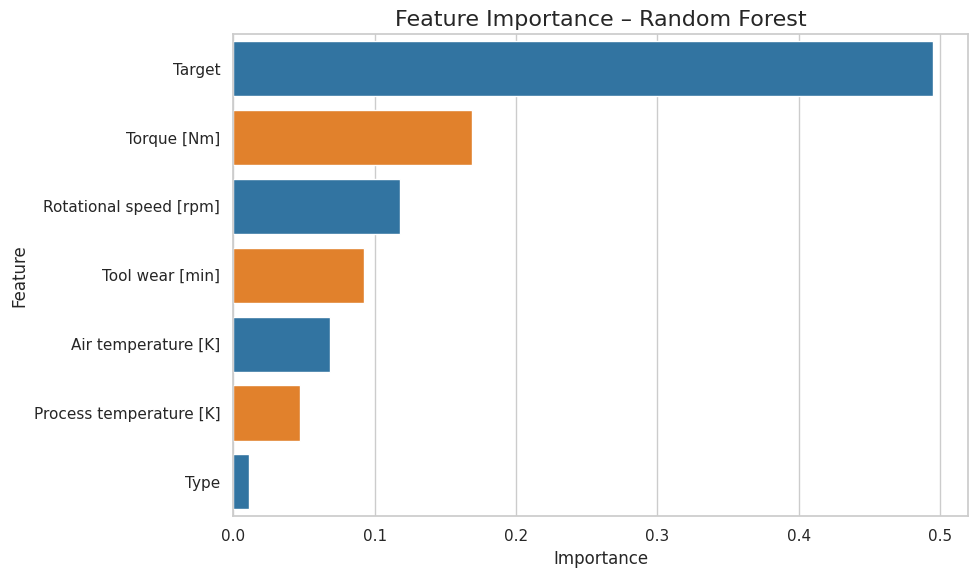


💾 Model saved successfully as 'random_forest_predictive_maintenance.pkl'


In [13]:
# ============================================================
# 16. Modeling – Random Forest Classifier
# ============================================================

# Define features (X) and target (y)
X = df.drop(columns=["Failure Type"])
y = df["Failure Type"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Random Forest model
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# ============================================================
# 17. Model Evaluation
# ============================================================

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))

# ============================================================
# 18. Visualize Confusion Matrix
# ============================================================

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix – Random Forest", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ============================================================
# 19. Feature Importance
# ============================================================

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette=PALETTE)
plt.title("Feature Importance – Random Forest", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ============================================================
# 20. Save Model (Optional)
# ============================================================

# Optionally save the trained model for reuse
import joblib
joblib.dump(model, "random_forest_predictive_maintenance.pkl")

print("\n💾 Model saved successfully as 'random_forest_predictive_maintenance.pkl'")
